# Projet Python pour le Data Scientist 

Projet réalisé par Eric Vong, Thibaut Valour et Solène Blasco Lopez

Ce projet Python utilise les données de l'OpenData de Paris sur l'encadrement des loyers de 2019, enrichies par l'intermédiaire de données web-scrapées sur internet. Il expérimente différents modèles de régression entrainés sur ces données dans le but de prédire les loyers de référence des appartements parisiens. L'objet de ce projet est donc de répondre à la problématique suivante : Quels sont les déterminants du loyer d'un bien immobilier parisien ?

In [1]:
import re

# Manipulation des donneés :
import pandas as pd
import geopandas as gpd

# Web-scraping :
import urllib
import bs4 

#Traitement des données :
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import Lasso, lasso_path

# Représentations graphiques :
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Partie 1 - récupération et traitement des données
*Les lignes de code qui suivent peuvent être trouvées dans le dossier `data` du dépôt git*

### 1. Récupération des données de la mairie de Paris concernant l'encadrement des loyers

La mairie de Paris a mis en ligne une base de données concernant l'encadrement des loyers de ses logements en 2019. On y trouve une classification des logements, selon leur secteur de localisation (quartier administratif) et leur type (nombre de pièces, époque de construction, meublé/non-meublé), accompagnée de leurs loyers de référence. 

*Lien contenant les informations sur ces données : https://opendata.paris.fr/explore/dataset/logement-encadrement-des-loyers/information/?disjunctive.id_zone&disjunctive.nom_quartier&disjunctive.piece&disjunctive.epoque&disjunctive.meuble_txt&sort=-id_zone&location=15,48.84958,2.34691&basemap=jawg.streets*

In [2]:
donnees_brutes = gpd.read_file('https://opendata.paris.fr/explore/dataset/logement-encadrement-des-loyers/download/?format=geojson&timezone=Europe/Berlin&lang=fr')

On ne sélectionne que les colonnes qui nous intérèssent : 
- `nom_quartier` et `id_quartier` : nom et id du quartier (administratif)
- `ref` : loyer de référence (encadrement : `min` et `max`)
- `epoque` : époque de construction de l'appartement
- `meuble_txt` : location en tant que logement meublé ou non-meublé
- `piece` : nombre de pièces
- `geometry` : représentation graphique du quartier.

In [3]:
donnees = donnees_brutes[['nom_quartier','id_quartier','ref','min','max','epoque','meuble_txt','piece','geometry']]

In [4]:
donnees.head(5)

,nom_quartier,id_quartier,ref,min,max,epoque,meuble_txt,piece,geometry
0,Belleville,77,25.0,17.50,30.00,1946-1970,meublé,2,"POLYGON ((2.38323 48.86710, 2.38314 48.86708, ..."
1,Belleville,77,23.6,16.52,28.32,Apres 1990,meublé,3,"POLYGON ((2.38323 48.86710, 2.38314 48.86708, ..."
2,Combat,76,19.8,13.86,23.76,1971-1990,meublé,4,"POLYGON ((2.38834 48.88057, 2.38950 48.87955, ..."
3,Amérique,75,21.6,15.12,25.92,1946-1970,meublé,2,"POLYGON ((2.40940 48.88019, 2.40995 48.87952, ..."
4,Saint-Fargeau,78,24.0,16.80,28.80,1971-1990,meublé,1,"POLYGON ((2.41381 48.87081, 2.41383 48.87066, ..."


Cette base de données référence 2560 appartements. On vérifie qu'il n'y a pas de valeurs manquantes :

In [5]:
donnees.count()

nom_quartier    2560
id_quartier     2560
ref             2560
min             2560
max             2560
epoque          2560
meuble_txt      2560
piece           2560
geometry        2560
dtype: int64

### 2. Création de deux variables : superficie des quartiers et leur distance au centre de Paris


In [6]:
donnees.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

On va devoir faire en sorte d'utiliser le système de projection `epsg 2154` dans la suite pour pouvoir obtenir des distances en mètres et des aires en mètres carrés.

- On ajoute la distance du centre de chaque quartier au centre de Paris dans la variable `distance_centre_paris` (intuition : plus un bien est proche du centre de Paris, plus il est convoité et donc valorisé) :

In [7]:
#Centres des quartiers :

df = donnees.centroid 
df = df.to_crs(epsg=2154)

In [8]:
#Centre de Paris (coordonnées trouvées sur internet): 

longitude = [2.3488 for i in range(2560)]
latitude = [48.8534 for i in range(2560)]

df2 = gpd.GeoDataFrame(geometry = gpd.points_from_xy(longitude, latitude),crs={'init': 'epsg:4326'})
df2 = df2.to_crs(epsg=2154)

In [9]:
# Tables des distances pour chaque appartement de la base de données :

distances = pd.DataFrame(df.distance(df2)*10**(-3),columns=["distance_centre_paris"])  #la multiplication par 10^3 convertit les mètres en kms

In [10]:
# Ajout de la nouvelle variable à la base de données : 

donnees = donnees.join(distances)

In [11]:
donnees.head(5)

,nom_quartier,id_quartier,ref,min,max,epoque,meuble_txt,piece,geometry,distance_centre_paris
0,Belleville,77,25.0,17.50,30.00,1946-1970,meublé,2,"POLYGON ((2.38323 48.86710, 2.38314 48.86708, ...",3.485188
1,Belleville,77,23.6,16.52,28.32,Apres 1990,meublé,3,"POLYGON ((2.38323 48.86710, 2.38314 48.86708, ...",3.485188
2,Combat,76,19.8,13.86,23.76,1971-1990,meublé,4,"POLYGON ((2.38834 48.88057, 2.38950 48.87955, ...",3.627396
3,Amérique,75,21.6,15.12,25.92,1946-1970,meublé,2,"POLYGON ((2.40940 48.88019, 2.40995 48.87952, ...",4.643892
4,Saint-Fargeau,78,24.0,16.80,28.80,1971-1990,meublé,1,"POLYGON ((2.41381 48.87081, 2.41383 48.87066, ...",4.643464


- On ajoute également la superficie de chaque quartier dans la variable `superficie_quartier` (intuition : plus un quartier est petit plus l'offre de logements est restreinte et les biens sont valorisés) :

In [12]:
# On ne conserve que les géométries, pour les passer dans le système espg 2154 :
df3 = donnees.geometry
df3 = df3.to_crs(epsg=2154)

In [13]:
#Création de la nouvelle variable :
donnees['superficie_quartier'] = df3.area.div(10**6)  #La division convertit les m² en km²

In [14]:
donnees.head(5)

,nom_quartier,id_quartier,ref,min,max,epoque,meuble_txt,piece,geometry,distance_centre_paris,superficie_quartier
0,Belleville,77,25.0,17.50,30.00,1946-1970,meublé,2,"POLYGON ((2.38323 48.86710, 2.38314 48.86708, ...",3.485188,0.806569
1,Belleville,77,23.6,16.52,28.32,Apres 1990,meublé,3,"POLYGON ((2.38323 48.86710, 2.38314 48.86708, ...",3.485188,0.806569
2,Combat,76,19.8,13.86,23.76,1971-1990,meublé,4,"POLYGON ((2.38834 48.88057, 2.38950 48.87955, ...",3.627396,1.294988
3,Amérique,75,21.6,15.12,25.92,1946-1970,meublé,2,"POLYGON ((2.40940 48.88019, 2.40995 48.87952, ...",4.643892,1.835720
4,Saint-Fargeau,78,24.0,16.80,28.80,1971-1990,meublé,1,"POLYGON ((2.41381 48.87081, 2.41383 48.87066, ...",4.643464,1.486971


### 3. Enrichissement des données : création d'un score lié aux stations de métro et de rer des quartiers

Pour enrichir ces données et mieux comprendre l'effet du quartier sur le loyer d'un logement, on ajoute une variable `score_metro` calculée de la manière suivante :
   - on liste les lignes distinctes de métro et de rer qui passent dans chaque quartier
   - on attribue un score à chaque ligne, qui correspond à sa fréquentation annuelle 
   - on somme pour chaque quartier les scores de ses lignes de métro/rer
   - Le score d'un quartier correspond alors à cette somme, divisée par la plus grande valeur attribuée à un quartier

De cette manière, on obtient un score compris entre 0 et 1 pour chaque quartier.    

Pour créer ce score, on récupère la liste des stations de métro et de rer de Paris, ainsi que leurs positions géographiques et leurs lignes desservies. Ces données sont récupérées sur Wikipédia par web-scraping. Pour chaque station, on récupère son nom et on se rend sur sa page Wikipédia pour récupérer ses coordonnées géographiques. Cette station est dupliquée pour chaque ligne de métro qu'elle dessert. 

*Les liens utilisés sont les suivants :*
- *Pour le métro : https://fr.wikipedia.org/wiki/Liste_des_stations_du_m%C3%A9tro_de_Paris*
- *Pour le rer : https://fr.wikipedia.org/wiki/Liste_des_gares_du_RER_d%27%C3%8Ele-de-France*

In [15]:
# Fonction pour transformer les coordonnées récoltées (sous format DMS nord-est) en format DD :

dd = lambda d,m,s : float(d) + float(m)/60 + float(s)/(60*60)
def dms_to_dd (dms):
    parts = re.split('[^\d\w]+', dms)
    lat = dd(parts[0], parts[1], parts[2])
    lng = dd(parts[4], parts[5], parts[6])
    return (lat, lng)

In [16]:
#Création de la base de données des stations de métro et de rer par web scraping : 

nom = []
ligne = [] 
latitude = []
longitude = []

urls = ['https://fr.wikipedia.org/wiki/Liste_des_stations_du_m%C3%A9tro_de_Paris','https://fr.wikipedia.org/wiki/Liste_des_gares_du_RER_d%27%C3%8Ele-de-France']

for url in urls : 

    sock = urllib.request.urlopen(url).read() 
    page=bs4.BeautifulSoup(sock)

    liste_stations = page.find('table').findAll('tr')
    
    for station in liste_stations[1:] :
    
        #Nom de la station :    
        nom_station = station.find('a').text
    
        #Coordonnées géographiques de la station :
        url_station = "http://fr.wikipedia.org"+station.find('a').get('href')
    
        search = urllib.request.urlopen(url_station).read()
        search_station=bs4.BeautifulSoup(search)
    
        coord = search_station.find('a',{'class': "mw-kartographer-maplink"}).text
        lat,lng = dms_to_dd(coord)
    
        #Lignes desservies par la station :    
        lignes = station.find('span',{'style' : "white-space:nowrap"}).findAll('span')
    
        for l in lignes : 
            nom.append(nom_station)
            ligne.append(l.get('data-sort-value'))
            latitude.append(lat)
            longitude.append(lng)
            
stations = gpd.GeoDataFrame(pd.DataFrame({'nom' : nom, 'ligne' : ligne}),geometry=gpd.points_from_xy(longitude, latitude))

In [17]:
stations.head(5)

,nom,ligne,geometry
0,Abbesses,12 !,POINT (2.33861 48.88444)
1,Alésia,04 !,POINT (2.32667 48.82833)
2,Alexandre Dumas,02 !,POINT (2.39500 48.85611)
3,Alma - Marceau,09 !,POINT (2.30028 48.86500)
4,Anatole France,03 !,POINT (2.28556 48.89194)


On récupère ensuite une base de données de la mairie de Paris contenant la liste de ses quartiers administratifs et leur représentation graphique :

In [18]:
quartiers_bruts = gpd.read_file('https://parisdata.opendatasoft.com/explore/dataset/quartier_paris/download/?format=geojson&timezone=Europe/Berlin&lang=fr')
quartiers = quartiers_bruts[['l_qu','c_qu','geometry']]  #l_qu : nom du quartier ; c_qu : numéro du quartier

In [19]:
quartiers.head(5)

,l_qu,c_qu,geometry
0,Sorbonne,20,"POLYGON ((2.34924 48.84452, 2.34888 48.84449, ..."
1,Saint-Georges,33,"POLYGON ((2.33923 48.87679, 2.33816 48.87686, ..."
2,Chaussée-d'Antin,34,"POLYGON ((2.33545 48.87683, 2.33710 48.87671, ..."
3,Palais-Royal,3,"POLYGON ((2.33947 48.86214, 2.33912 48.86148, ..."
4,Europe,32,"POLYGON ((2.31229 48.87330, 2.31152 48.87308, ..."


On associe ensuite à chaque station le quartier auquel elle appartient :

In [20]:
stations_quartiers = gpd.sjoin(stations, quartiers, op='intersects')


Il ne reste plus qu'à supprimer les doublons pour savoir quelles lignes de métro ou rer passent dans chaque quartier de Paris. 

In [21]:
lignes_quartiers = stations_quartiers[['c_qu','ligne']].drop_duplicates()

In [22]:
lignes_quartiers.tail(5)

,c_qu,ligne
346,11,08 !
349,7,03 !
361,15,07 !
369,4,01 !
453,19,B !


Ensuite, on réalise un nouveau web scraping sur Wikipédia pour attribuer un score à chaque ligne : on va lister chaque ligne et sa fréquentation annuelle, divisée par la fréquentation annuelle la plus élevée.

In [23]:
#Pour le rer, il faut aller sur chaque page Wikipédia de la ligne. Pour aller plus vite, on le fait manuellement (il n'y a que 5 lignes) :

lignes = ['A !','B !','C !','D !','E !']
frequentation = [309.36,165.5,140,145,60] 


#Pour le métro, il existe directement un classement sur Wikipédia :

sock = urllib.request.urlopen("https://fr.wikipedia.org/wiki/Liste_des_lignes_de_m%C3%A9tro_parisiennes_par_fr%C3%A9quentation").read() 
page=bs4.BeautifulSoup(sock)

liste_lignes = page.find('table').findAll('tr')

for ligne in liste_lignes[1:] :
    
    freq = ligne.find('bdi')
    
    for sous_ligne in ligne.findAll('span') :
        lignes.append(sous_ligne.get('data-sort-value'))
        frequentation.append(float(freq.text.replace(',','.')))
        
lignes_freq = pd.DataFrame({'ligne' : lignes,'fréquentation' : frequentation})

In [24]:
lignes_freq.head(5)

,ligne,fréquentation
0,A !,309.36
1,B !,165.50
2,C !,140.00
3,D !,145.00
4,E !,60.00


In [25]:
# Ajout du score des lignes pour chaque quartier : 

lignes_quartiers_freq = lignes_quartiers.merge(lignes_freq, on='ligne')

In [26]:
#Création du score des quartiers : 

quartiers_freq = lignes_quartiers_freq[['c_qu','fréquentation']].groupby('c_qu').sum()

m = max(quartiers_freq['fréquentation'])

quartiers_freq['fréquentation'] = quartiers_freq['fréquentation']/m

Pour finir, on ajoute le score obtenu à notre base de données :

In [27]:
donnees_augmentees = donnees.join(quartiers_freq, on='id_quartier')
donnees_augmentees.rename(columns={'fréquentation': 'score_metro'}, inplace=True)

In [28]:
donnees_augmentees.head(5)

,nom_quartier,id_quartier,ref,min,max,epoque,meuble_txt,piece,geometry,distance_centre_paris,superficie_quartier,score_metro
0,Belleville,77,25.0,17.50,30.00,1946-1970,meublé,2,"POLYGON ((2.38323 48.86710, 2.38314 48.86708, ...",3.485188,0.806569,0.038651
1,Belleville,77,23.6,16.52,28.32,Apres 1990,meublé,3,"POLYGON ((2.38323 48.86710, 2.38314 48.86708, ...",3.485188,0.806569,0.038651
2,Combat,76,19.8,13.86,23.76,1971-1990,meublé,4,"POLYGON ((2.38834 48.88057, 2.38950 48.87955, ...",3.627396,1.294988,0.128401
3,Amérique,75,21.6,15.12,25.92,1946-1970,meublé,2,"POLYGON ((2.40940 48.88019, 2.40995 48.87952, ...",4.643892,1.835720,0.369742
4,Saint-Fargeau,78,24.0,16.80,28.80,1971-1990,meublé,1,"POLYGON ((2.41381 48.87081, 2.41383 48.87066, ...",4.643464,1.486971,0.186527


### Eventuelles limites de ce score : 

On a ici créer par nous mêmes un score pour chaque quartier, d'autant plus élévé que les lignes de métro et rer qui passent dans un quartier sont nombreuses et importantes en termes de fréquentation.

Cependant, il convient de noter les éventuelles limites de ce score : 
- on ne prend pas en compte les stations de vélib et les autres types de transports
- les quartiers ont des tailles très diverses : les grands quartiers aux extrémités ouest et est de Paris ne sont donc pas forcément très bien représentés en termes de transports via seulement le métro et le rer. On constate sur le graphique suivant qu'une majorité de la superficie de ces quartiers n'est pas désservie par le métro ou le rer.
- on ne regarde ici que les lignes qui passent dans un quartier. Mais, pour les petits quartiers du centre de Paris par exemple, il est très facile d'accéder sans trop de temps aux stations des quartiers voisins. Pour les plus grand quartiers, si l'on habite proche des frontières on peut par exemple préférer les stations du quartier d'à côté, plus proches, que les stations à l'autre bout de son propre quartier. 

In [29]:
quartiers.head()

,l_qu,c_qu,geometry
0,Sorbonne,20,"POLYGON ((2.34924 48.84452, 2.34888 48.84449, ..."
1,Saint-Georges,33,"POLYGON ((2.33923 48.87679, 2.33816 48.87686, ..."
2,Chaussée-d'Antin,34,"POLYGON ((2.33545 48.87683, 2.33710 48.87671, ..."
3,Palais-Royal,3,"POLYGON ((2.33947 48.86214, 2.33912 48.86148, ..."
4,Europe,32,"POLYGON ((2.31229 48.87330, 2.31152 48.87308, ..."


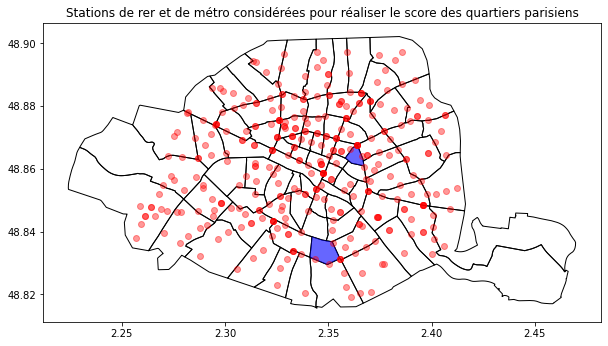

In [30]:
axi = stations_quartiers.plot(figsize = (10,10), color = 'red', alpha = 0.4, zorder=2)
quartiers.plot(ax = axi, zorder=1, edgecolor = "black", facecolor="none",
                                                           color = None)
quartiers[quartiers['c_qu'].isin([10,52])].plot(ax=axi,alpha = 0.6,color='blue')
plt.title("Stations de rer et de métro considérées pour réaliser le score des quartiers parisiens")
plt.show()

On remarque de plus que certaines stations de métro et rer sont situées sur les limites ou proches des limites des quartiers, et ne sont donc prises en compte que pour un seul quartier. Certains quartiers se retrouvent alors sans score :

In [31]:
donnees_augmentees[['nom_quartier','id_quartier','score_metro']][donnees_augmentees.isnull().any(axis=1)].drop_duplicates()

,nom_quartier,id_quartier,score_metro
28,Enfants-Rouges,10,NaN
106,Croulebarbe,52,NaN


Les quartiers sans scores sont les quartiers représentés en bleu sur la carte précédente : Enfants-Rouges (10) et Croulebarbe (52). On remarque qu'ils n'ont pas de score car les stations de métro sont situées au niveau de leurs limites... Il ne serait donc pas cohérent de leur mettre un score nul d'office... 

Les quartiers mal représentés par ce score car mal desservis par le métro et le rer sont les trois grands quartiers à l'ouest : Auteuil (61), Muette (62), Porte-Dauphine (63) ; et les deux grands quartiers à l'est : Pictus (46) et Bel-Air (45).

De façon attendue, lorsqu'on prend un bien immobilier situé dans le même quartier et datant de la même époque, le bien qui sera meublé coûtera plus cher que le bien non meublé. 

On peut remarquer que les appartements historiques (avant 1946) sont les plus chers suivi par les appartements très modernes (post 1990), cela peut s'expliquer par des raisons historiques : les appartements entre 1946 et 1990 ont été construits pendant la période (et peu après) des 30 glorieuses, il fallait loger beaucoup de monde rapidement, ils sont donc moins travaillés esthétiquements que ceux avant et après cette période. 

## Partie 2 - Modélisation
*Les lignes de code qui suivent peuvent être trouvées dans les dossiers `preprocessing` et `visualization` du dépôt git*

### 1. Preprocessing

Pour commencer, on crée une nouvelle base de données dans laquelle toutes les variables sont sous forme numérique. Cette nouvelle base de données, qui nommée `donnees_num.geojson` peut être trouvée dans le dossier `preprocessing`du dépôt git.


In [32]:
donnees_num = donnees_augmentees.copy()

- Variable `meuble_txt` : 
Elle est transformée en une variable binaire `meuble_bin` telle que :
    - meuble_bin = 1 si l'appartement est meublé
    - meuble_bin = 0 si l'appartement est non-meublé

Comme on n'a que deux modalités, on peut utiliser `LabelEncoder`.

In [33]:
donnees_num['meuble_bin'] = 1 - LabelEncoder().fit_transform(donnees_num['meuble_txt'])

#Suppression de 'meuble_txt' :
donnees_num.drop('meuble_txt',axis=1,inplace=True)

- Variable `id_quartier` : 
il y a 80 modalités, donc on crée 80 nouvelles variables `q_i` pour $1\leq i \leq80$ telles que : 
    - `q_i` = 1 si `id_quartier` = i
    - `q_i` = 0 si `id_quartier` != i

Comme on a 80 modalités, on utilise cette fois `OneHotEncoder`.

In [34]:
donnees_num = donnees_num.sort_values('id_quartier').reset_index()
ohe_id_quartier = pd.DataFrame(LabelBinarizer().fit_transform(donnees_num['id_quartier']))

# On renomme les colonnes sous la forme : q_[1-80]
colonnes = {}
for i in range(80) :
    colonnes[i] = 'q_'+str(i+1)
ohe_id_quartier.rename(columns=colonnes, inplace=True)

# Ajout des nouvelles variables et suppression de 'nom_quartier' et 'id_quartier' :
donnees_num = donnees_num.join(ohe_id_quartier)
donnees_num.drop(['nom_quartier','id_quartier','index'],axis=1,inplace=True)

- Variable `epoque` : 
il y a 4 modalités, donc on crée 4 nouvelles variables `epoque_i` pour $0 \leq i\leq 3$ telles que : 
    - `epoque_0` = 1 si `epoque` = 'Avant 1946', et 0 sinon
    - `epoque_1` = 1 si `epoque` =  '1946-1970', et 0 sinon
    - `epoque_2` = 1 si `epoque` = '1971-1990', et 0 sinon
    - `epoque_3` = 1 si `epoque` =  'Apres 1990', et 0 sinon

On utilise encore une fois `OneHotEncoder`.

In [35]:
ohe_epoque = pd.DataFrame(LabelBinarizer().fit_transform(donnees_num['epoque']))

# On renomme les colonnes sous la forme : epoque_[0-79]

#donnees[['epoque']].head(10) #pour savoir comment renommer chaque colonne
colonnes = {0 : 'epoque_1', 1 : 'epoque_2', 2 : 'epoque_3', 3 : 'epoque_0'}  
ohe_epoque.rename(columns=colonnes, inplace=True)

# Ajout des nouvelles variables et suppression de 'epoque' :
donnees_num = donnees_num.join(ohe_epoque)
donnees_num.drop(['epoque'],axis=1,inplace=True)

In [75]:
donnees_num.head(2)

,ref,piece,distance_centre_paris,superficie_quartier,score_metro,meuble_bin,epoque_1,epoque_2,epoque_3
0,32.1,1,1.299442,0.869001,0.603253,0,0,0,1
1,22.2,4,1.299442,0.869001,0.603253,0,0,1,0


On crée également une fonction permettant de standardiser une base de données numériques passée en argument :

In [37]:
def standardisation(df) :
    """
    Fonction renvoyant la version standardisée d'une base de données df passée en argument.
    
    ! df ne doit contenir que des variables numériques !
    """
    
    data = StandardScaler().fit(df).transform(df.fillna(0))
    
    return data

### 2. Modèle LASSO - sélection des variables

Ce modèle permet de sélectionner les variables d'intérêt. 

On utilise la base de données numérique `donnees_num`, à laquelle : 
   - on enlève les variables qui ne nous intérèssent pas : `min`, `max` et `geometry`
   - on enlève l'une des variables de chaque groupe de variables corrélées :
        - `q_80` pour le groupe de variables corrélées `q_i`, $1 \leq i \leq80$
        - `epoque_0` pour le groupe de variables corrélées `epoque_i`, $0 \leq i \leq3$
   - on standardise les variables restantes

In [38]:
donnees_lasso = donnees_num.copy()

donnees_lasso.drop(['min','max','geometry','q_80','epoque_0'],axis=1,inplace=True)

data_lasso = standardisation(donnees_lasso)

On va ensuite tester le modèle LASSO avec différentes valeurs d'hyper-paramètre $\alpha$, et représenter le nombre de variables sélectionnées en fonction de $\alpha$ :

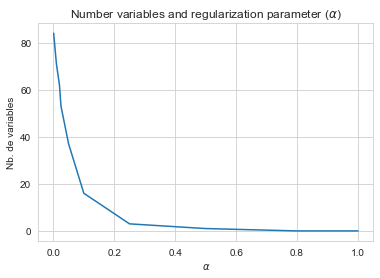

In [39]:
yindex = donnees_lasso.columns.get_loc("ref")
alphas = np.array([0.001,0.01,0.02,0.025,0.05,0.1,0.25,0.5,0.8,1.0])

alpha_for_path, coefs_lasso, _ = lasso_path(np.delete(data_lasso, yindex, axis = 1),data_lasso[:,yindex],alphas=alphas)
nb_non_zero = np.apply_along_axis(func1d=np.count_nonzero,arr=coefs_lasso,axis=0)

sns.set_style("whitegrid")
p = sns.lineplot(y=nb_non_zero, x=alpha_for_path).set(title = r"Number variables and regularization parameter ($\alpha$)", xlabel=r'$\alpha$', ylabel='Nb. de variables')
p
plt.show()

$\hookrightarrow$ On remarque que le nombre de variables sélectionnées décroit très rapidement. On peut supposer que cela est du au fait que si on établit que le quartier n'a pas d'influence sur le loyer, on peut directement écarter 79 variables...

Au vu du graphique précédent, on peut penser que la meilleure valeur de l'hyperparamètre serait aux alentours de $\alpha = 0.15$, zone d'inflexion de la courbe. On va donc tester le modèle LASSO avec ce paramètre pour voir quelles variables sont retenues pour expliquer le loyer des appartements.

In [40]:
alpha = 0.15

lasso1 = Lasso(fit_intercept=False,normalize=False, alpha = alpha)
lasso1.fit(np.delete(data_lasso, yindex, axis = 1),data_lasso[:,yindex])

print("Coefficients estimés par modèle LASSO : ")
print(np.abs(lasso1.coef_))

print("Colonnes sélectionnées par modèle LASSO : ")
print(donnees_lasso.drop("ref", axis = 1).columns[np.abs(lasso1.coef_)>0])


Coefficients estimés par modèle LASSO : 
[0.3980399  0.13119295 0.         0.         0.22604745 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
Colonnes sélectionnées par modèle LASSO : 
Index(['piece', 'distance_centre_paris', 'meuble_bin'],

$\hookrightarrow$ Le modèle LASSO avec $\alpha = 0.15$ sélectionne donc le nombre de pièces comme ayant la plus grande incidence sur le loyer. Il sélectionne également la distance au centre de Paris, qui est une information sur les quartiers, et le fait que le logement soit proposé comme meublé ou non.

On peut éssayer avec un  $\alpha$ légèrement plus petit, pour sélectionner un peu plus de variables :

In [41]:
alpha = 0.13

lasso1 = Lasso(fit_intercept=False,normalize=False, alpha = alpha)
lasso1.fit(np.delete(data_lasso, yindex, axis = 1),data_lasso[:,yindex])

print("Coefficients estimés par modèle LASSO : ")
print(np.abs(lasso1.coef_))

print("Colonnes sélectionnées par modèle LASSO : ")
print(donnees_lasso.drop("ref", axis = 1).columns[np.abs(lasso1.coef_)>0])

Coefficients estimés par modèle LASSO : 
[0.4180399  0.1511576  0.         0.         0.24604745 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00141474 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.01943677 0.00945549 0.        ]
Colonnes sélectionnées par modèle LASSO : 
Index(['piece', 'distance_centre_paris', 'meuble_bin', 

$\hookrightarrow$ Si on diminue légèrement $\alpha$ pour prendre $\alpha=0.13$, on remarque que deux des variables correspondant à l'époque de construction et la variable indicatrice du quartier Gare (50) sont également sélectionnées, mais obtiennent des coefficients beaucoup plus petits. 

Partie 3 - Statistiques descriptives et analyse

Les lignes de code peuvent être trouvé dans le dossier visualization du  dépôt git.

In [57]:
analyse = donnees_augmentees.groupby(['nom_quartier','meuble_bin','epoque']).mean()
todrop=['id_quartier','min','max']
analyse.drop(todrop,axis=1,inplace=True)
analyse.head(16)

ref  piece  distance_centre_paris  \
nom_quartier meuble_bin epoque                                             
Amérique     0          1946-1970   18.275    2.5               4.643892   
                        1971-1990   17.700    2.5               4.643892   
                        Apres 1990  19.625    2.5               4.643892   
                        Avant 1946  22.150    2.5               4.643892   
             1          1946-1970   20.650    2.5               4.643892   
                        1971-1990   20.025    2.5               4.643892   
                        Apres 1990  22.150    2.5               4.643892   
                        Avant 1946  25.050    2.5               4.643892   
Archives     0          1946-1970   24.275    2.5               1.237744   
                        1971-1990   25.000    2.5               1.237744   
                        Apres 1990  25.425    2.5               1.237744   
                        Avant 1946  27.225    2.5               1.237744   
             1          1946-1970   27.450    2.5               1.237744   
                        1971-1990   28.250    2.5               1.237744   
                        Apres 1990  28.725    2.5               1.237744   
                        Avant 1946  30.775    2.5               1.237744   

                                    superficie_quartier  score_metro  
nom_quartier meuble_bin epoque                                        
Amérique     0          1946-1970              1.835720     0.369742  
                        1971-1990              1.835720     0.369742  
                        Apres 1990             1.835720     0.369742  
                        Avant 1946             1.835720     0.369742  
             1          1946-1970              1.835720     0.369742  
                        1971-1990              1.835720     0.369742  
                        Apres 1990             1.835720     0.369742  
                        Avant 1946             1.835720     0.369742  
Archives     0          1946-1970              0.367728     0.101295  
                        1971-1990              0.367728     0.101295  
                        Apres 1990             0.367728     0.101295  
                        Avant 1946             0.367728     0.101295  
             1          1946-1970              0.367728     0.101295  
                        1971-1990              0.367728     0.101295  
                        Apres 1990             0.367728     0.101295  
                        Avant 1946             0.367728     0.101295

De façon attendue, lorsqu'on prend un bien immobilier situé dans le même quartier et datant de la même époque, le bien qui sera meublé coûtera plus cher que le bien non meublé. 

On peut remarquer que les appartements historiques (avant 1946) sont les plus chers suivi par les appartements très modernes (post 1990), cela peut s'expliquer par des raisons historiques : les appartements entre 1946 et 1990 ont été construits pendant la période (et peu après) des 30 glorieuses, il fallait loger beaucoup de monde rapidement, ils sont donc moins travaillés esthétiquements que ceux avant et après cette période. 


In [70]:
donnees_acp = donnees_num.copy()
todrop = ['q_'+str(i+1) for i in range(79)]
donnees_acp.drop(todrop,axis=1,inplace=True)

,ref,piece,distance_centre_paris,superficie_quartier,score_metro,meuble_bin,epoque_1,epoque_2,epoque_3
0,32.1,1,1.299442,0.869001,0.603253,0,0,0,1
1,22.2,4,1.299442,0.869001,0.603253,0,0,1,0
2,29.6,4,1.299442,0.869001,0.603253,1,0,0,1
3,21.7,3,1.299442,0.869001,0.603253,0,1,0,0
4,31.9,1,1.299442,0.869001,0.603253,0,1,0,0
...,...,...,...,...,...,...,...,...,...
2555,26.0,1,4.304793,2.090904,0.239635,0,0,0,0
2556,25.9,1,4.304793,2.090904,0.239635,1,1,0,0
2557,16.5,3,4.304793,2.090904,0.239635,0,1,0,0
2558,29.4,1,4.304793,2.090904,0.239635,1,0,0,0


On regénère les données utilisées et on les numérise afin de pouvoir effectuer une ACP sur les données. On ne prendra pas en compte les quartiers puisqu'ils vont avoir une contribution non nulle à chaque composante la rendant inutilisable. De plus, on peut justifier ce choix par le fait que les quartiers sont identifiables par le score du métro, la superficie et la distance au centre de Paris.

In [ ]:
donnees_acp = donnees_acp.fillna(0)
features = [donnees_acp.columns[i] for i in range(len(donnees.columns))]
x = donnees_acp.loc[:,features].values
x = StandardScaler().fit_transform(x)

Certains quartiers n'ont pas de score de métro, nous leur assignons donc 0 même si cela est discutable comme vu précédemment, nous prenons toutes les variables dans nos données et nous les normalisons pour pouvoir effectuer une ACP.

In [ ]:
n_components = len(donnees.columns)
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component' + str(i+1) for i in range(len(donnees_acp.columns))])

On effectue l'ACP, on garde le même nombre de composantes principales que de variables, cela nous permettra d'avoir une variance explicative égale à 1, nous choissirons ensuite les variables les plus appropriées.

In [ ]:
pca.explained_variance_ratio_

On voit que les 2 dernières variables de l'ACP expliquent peu (contribution de 2.5%), on peut prendre 6 composantes principales (même si cela est à discuter, la règle du coude étant inutilisable ici, on en prend 6 plutôt que 7 car la 7ème a une contribution inférieure à 1/9)

In [ ]:
ind = np.arange(0, n_components)
(fig, ax) = plt.subplots(figsize=(8, 6))
sns.pointplot(x=ind, y=pca.explained_variance_ratio_)
ax.set_title('Scree plot')
ax.set_xticks(ind)
ax.set_xticklabels(ind)
ax.set_xlabel('Component Number')
ax.set_ylabel('Explained Variance')
plt.show()


In [ ]:
(fig, ax) = plt.subplots(figsize=(8, 8))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,0,pca.components_[0, i],pca.components_[1, i],head_length=0.1)
    plt.text(pca.components_[0, i] + 0.05,pca.components_[1, i] + 0.05,donnees_acp.columns.values[i])

an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  #Cercle unité pour référence
plt.axis('equal')
ax.set_title('Variable factor map')
plt.show()


Effectuons une ACP sur les variables obtenues par le modèle de Lasso pour voir si nous pouvons encore restreindre le nombre de variable.

In [ ]:
donnees_lasso_acp = donnees_augmentees.copy()
todrop = []